In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 512
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -146.57782247848212
max pF: 2.5253136357059445
max photon: 30.72699609771371
photon time: 0.8013310200741781
smoothness: 0.004047764788710292
global update: 200
reward: -80.28672553876488
max pF: 2.55730284239534
max photon: 39.47179866582155
photon time: 0.7800985984227036
smoothness: 0.002474116490058965
global update: 300
reward: -35.41559025522566
max pF: 2.56096785139144
max photon: 40.76890539377928
photon time: 0.6846559815259479
smoothness: 0.0014276209857026195
global update: 400
reward: -3.1614456578907655
max pF: 2.556641957722416
max photon: 39.88225677609444
photon time: 0.4022511049681634
smoothness: 0.0007486067928196242
global update: 500
reward: 9.084765868457595
max pF: 2.5601122541360084
max photon: 40.28799131512642
photon time: 0.36940442225105247
smoothness: 0.00047809320557700027
global update: 600
reward: 17.19311969345584
max pF: 2.5597882084029653
max photon: 40.41492985188961
photon time: 0.35708132639

In [5]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
actions = metrics["action"]

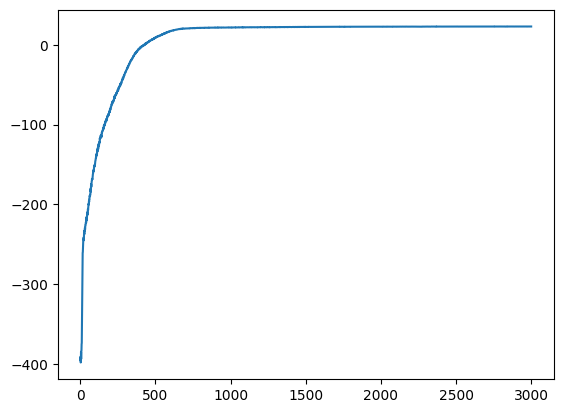

In [6]:
plt.plot(jnp.mean(rewards, axis=-1))
plt.show()

(3000, 512, 121)


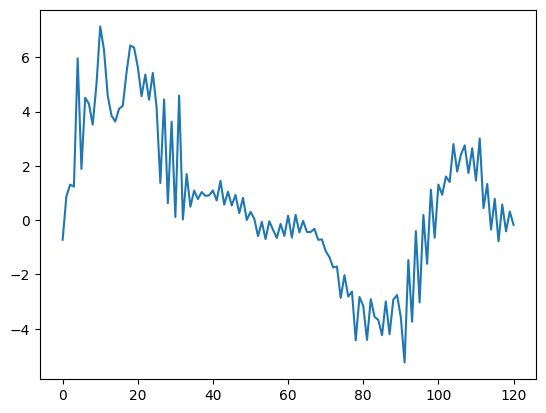

In [7]:
print(actions.shape)
mean_actions = jnp.mean(actions, axis=1)

plt.plot(mean_actions[-1])
plt.show()

In [8]:
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

single_env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

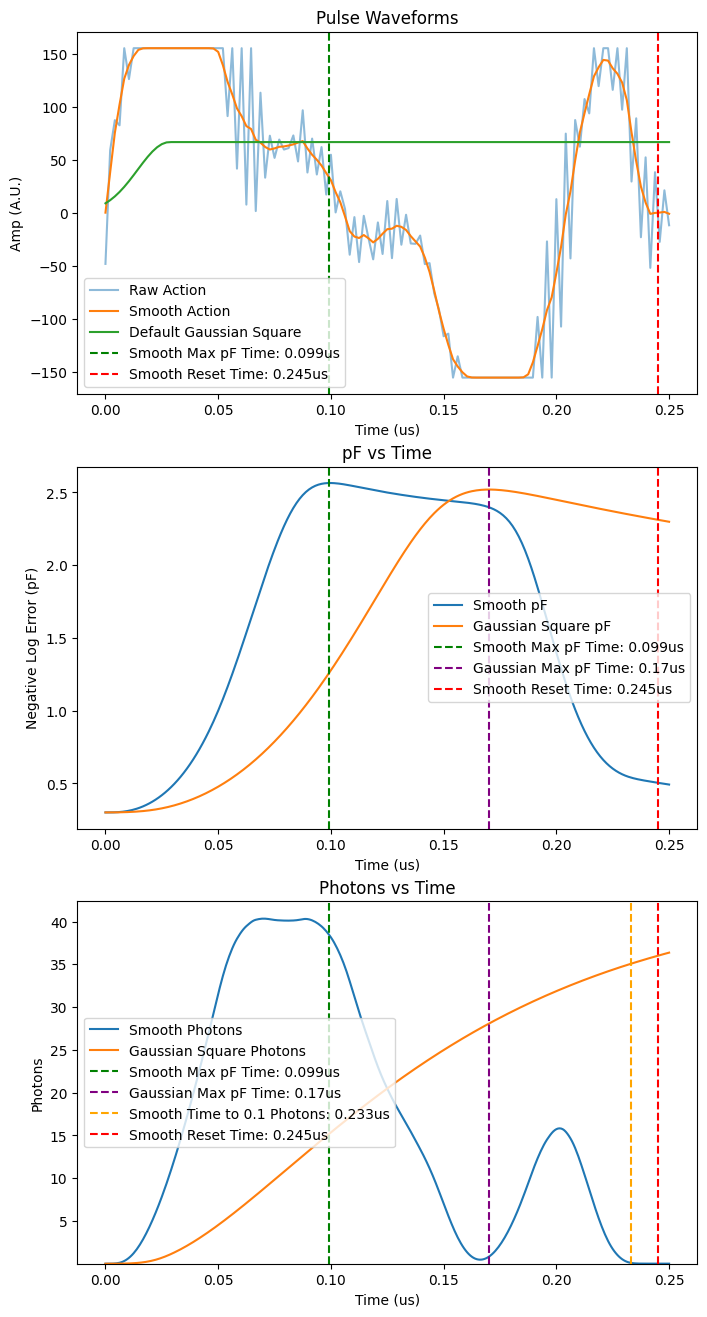

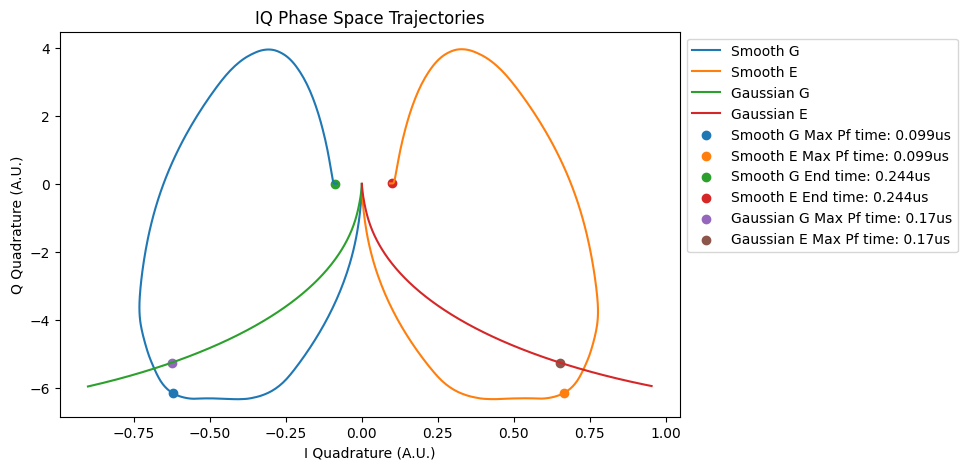

In [9]:
single_env.rollout_action(
    raw_action=mean_actions[-1],
    time_below_photon_val=0.1,
    photon_log_scale=False
)

155.64562302652888


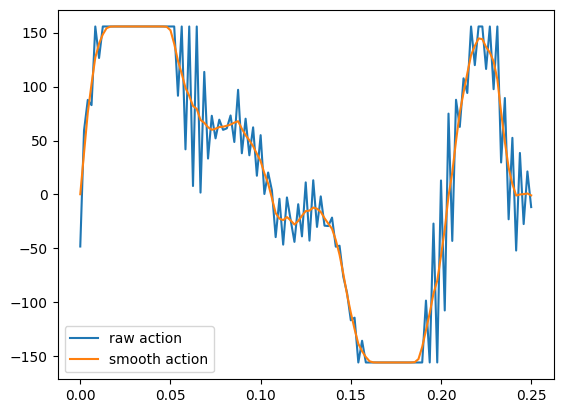

In [12]:
final_action = mean_actions[-1] * single_env.a0
normalizing_factor = jnp.clip(
    single_env.mu * single_env.a0 / jnp.absolute(final_action),
    0.0,
    1.0,
)
final_action *= normalizing_factor
smooth_action = single_env.drive_smoother(final_action)

print(single_env.a0 * single_env.mu)

plt.plot(single_env.ts_action, final_action, label='raw action')
plt.plot(single_env.ts_action, smooth_action, label='smooth action')
plt.legend()
plt.show()

In [17]:
single_result = single_env.calc_results(smooth_action)
(
    max_pf,
    max_photon,
    photon_reset_time,
    pulse_end_time,
    max_pf_time,
    smoothness,
    pF,
    higher_photons,
    pulse_reset_val,
) = single_env.extract_values(single_result, smooth_action)

print(f"Max pF: {max_pf}")
print(f"Max Photon: {max_photon}")
print(f"Photon Reset Time: {photon_reset_time}")
print(f"Pulse End Time: {pulse_end_time}")
print(f"Max pF Time: {max_pf_time}")

Max pF: 2.564761172709617
Max Photon: 40.3490928244651
Photon Reset Time: 0.24472725972204823
Pulse End Time: 0.24375000000000002
Max pF Time: 0.09930555555555556


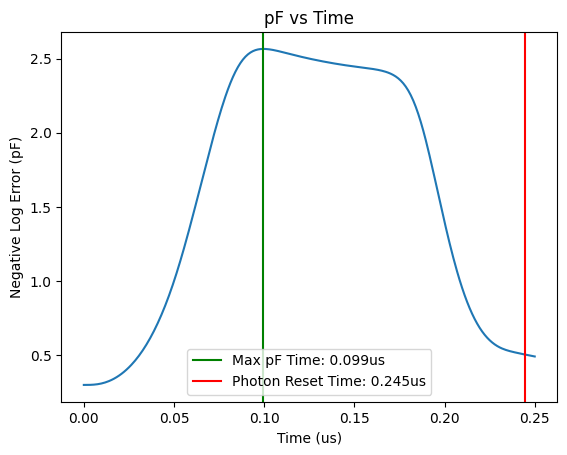

In [26]:
plt.plot(single_env.ts_sim, pF)
plt.axvline(x=max_pf_time, color='green', label=f'Max pF Time: {jnp.round(max_pf_time, 3)}us')
plt.axvline(x=photon_reset_time, color='red', label=f'Photon Reset Time: {jnp.round(photon_reset_time, 3)}us')
plt.ylabel('Negative Log Error (pF)')
plt.xlabel('Time (us)')
plt.title('pF vs Time')
plt.legend()
plt.show()

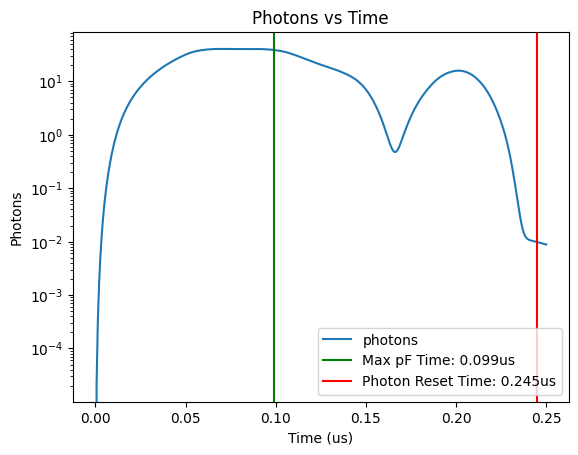

In [27]:
plt.plot(single_env.ts_sim, higher_photons, label='photons')
plt.yscale('log')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.axvline(x=max_pf_time, color='green', label=f'Max pF Time: {jnp.round(max_pf_time, 3)}us')
plt.axvline(x=photon_reset_time, color='red', label=f'Photon Reset Time: {jnp.round(photon_reset_time, 3)}us')
plt.legend()
plt.show()

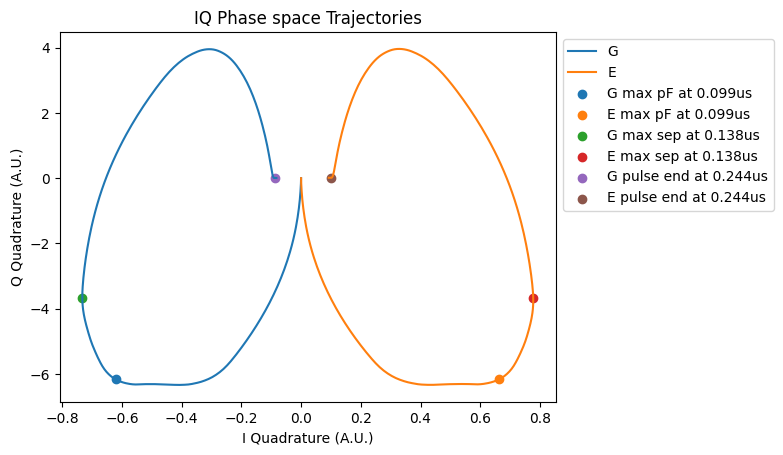

In [34]:
res_g = single_result[:, 0] + 1.0j * single_result[:, 1]
res_e = single_result[:, 2] + 1.0j * single_result[:, 3]

# Plotting Points of Interest, including
# Max pF
# Max Separation
# Pulse End

max_pf_index = jnp.argmin(jnp.abs(single_env.ts_sim - max_pf_time))
max_sep_index = jnp.argmax(jnp.abs(res_g - res_e))
pulse_end_index = jnp.argmin(jnp.abs(single_env.ts_sim - pulse_end_time))

plt.plot(res_g.real, res_g.imag, label='G')
plt.plot(res_e.real, res_e.imag, label='E')
plt.scatter(res_g[max_pf_index].real, res_g[max_pf_index].imag, label=f'G max pF at {jnp.round(max_pf_time, 3)}us')
plt.scatter(res_e[max_pf_index].real, res_e[max_pf_index].imag, label=f'E max pF at {jnp.round(max_pf_time, 3)}us')
plt.scatter(res_g[max_sep_index].real, res_g[max_sep_index].imag, label=f'G max sep at {jnp.round(single_env.ts_sim[max_sep_index], 3)}us')
plt.scatter(res_e[max_sep_index].real, res_e[max_sep_index].imag, label=f'E max sep at {jnp.round(single_env.ts_sim[max_sep_index], 3)}us')
plt.scatter(res_g[pulse_end_index].real, res_g[pulse_end_index].imag, label=f'G pulse end at {jnp.round(pulse_end_time, 3)}us')
plt.scatter(res_e[pulse_end_index].real, res_e[pulse_end_index].imag, label=f'E pulse end at {jnp.round(pulse_end_time, 3)}us')
plt.legend(bbox_to_anchor=(1.,1.))
plt.xlabel('I Quadrature (A.U.)')
plt.ylabel('Q Quadrature (A.U.)')
plt.title('IQ Phase space Trajectories')
plt.show()

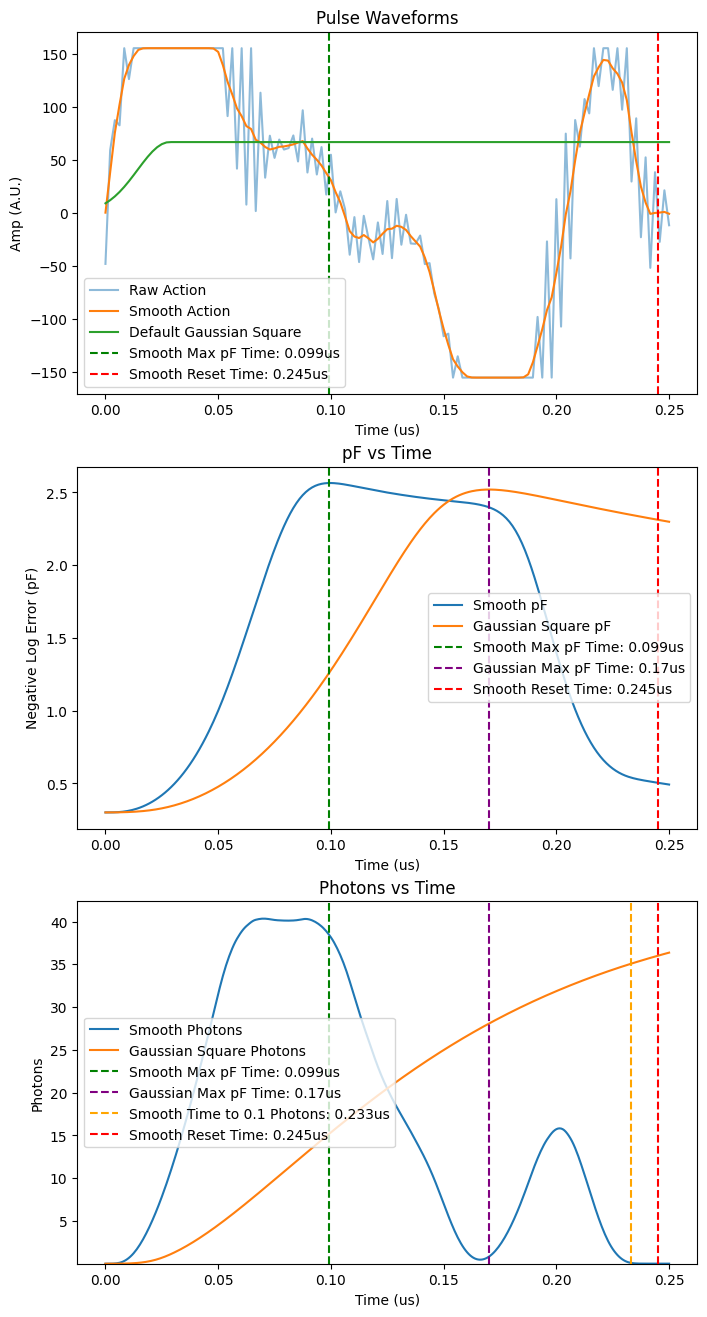

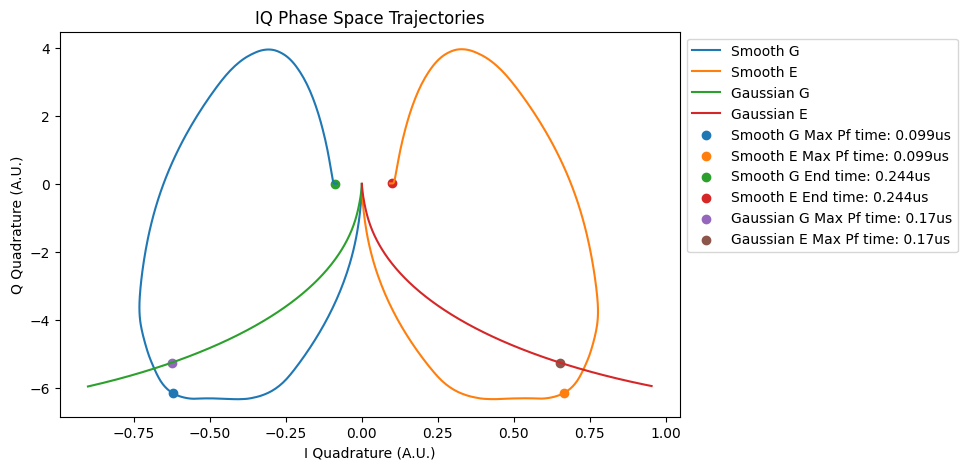

In [62]:
### Plotting Everything Together ###

import chex
from typing import Optional

def rollout_action(
    raw_action: chex.Array,
    time_below_photon_val: Optional[float] = 0.1,
    photon_log_scale: Optional[bool] = False,
):
    ts_sim = single_env.ts_sim
    ts_action = single_env.ts_action

    fig, ax = plt.subplots(3, figsize=(8.0, 16.0))

    # Obtaining Raw Action vs Smooth Action
    raw_action *= single_env.a0
    normalizing_factor = jnp.clip(
        single_env.mu * single_env.a0 / jnp.absolute(raw_action),
        0.0,
        1.0,
    )
    raw_action *= normalizing_factor
    smooth_action = single_env.drive_smoother(raw_action)

    # Defining Default Gaussian Square Readout
    # Gaussian Edge with sigma and duration
    # Constant Amplitude for certain duration
    total_default_duration = 0.398
    gaussian_edge_sigma = 64 / 4.5 / 1000.
    gaussian_edge_duration = 2. * gaussian_edge_sigma
    gaussian_square_readout = single_env.a0 * jnp.heaviside(ts_action - gaussian_edge_duration, 0.)
    gaussian_square_readout *= jnp.heaviside(total_default_duration - gaussian_edge_duration - ts_action, 1.)
    gaussian_square_readout += single_env.a0 * jnp.exp(-(ts_action - gaussian_edge_duration)**2 / (2 * gaussian_edge_sigma**2)) * jnp.heaviside(gaussian_edge_duration - ts_action, 1.)
    gaussian_square_readout += single_env.a0 * jnp.exp(-(ts_action - (total_default_duration - gaussian_edge_duration))**2 / (2 * gaussian_edge_sigma**2)) * jnp.heaviside(gaussian_edge_duration - ts_action, 1.)

    # Obtaining Results for Smooth Action and Gaussian Square
    smooth_results = single_env.calc_results(smooth_action)
    (
        s_max_pf,
        s_max_photon,
        s_photon_reset_time,
        s_pulse_end_time,
        s_max_pf_time,
        s_smoothness,
        s_pF,
        s_higher_photons,
        s_pulse_reset_val,
    ) = single_env.extract_values(smooth_results, smooth_action)

    s_photon_reset_time = jnp.round(s_photon_reset_time, 3)
    s_pulse_end_time = jnp.round(s_pulse_end_time, 3)
    s_max_pf_time = jnp.round(s_max_pf_time, 3)

    gaussian_results = single_env.calc_results(gaussian_square_readout)
    (
        g_max_pf,
        g_max_photon,
        g_photon_reset_time,
        g_pulse_end_time,
        g_max_pf_time,
        g_smoothness,
        g_pF,
        g_higher_photons,
        g_pulse_reset_val,
    ) = single_env.extract_values(gaussian_results, gaussian_square_readout)

    g_photon_reset_time = jnp.round(g_photon_reset_time, 3)
    g_pulse_end_time = jnp.round(g_pulse_end_time, 3)
    g_max_pf_time = jnp.round(g_max_pf_time, 3)

    smooth_g = smooth_results[:, 0] + 1.0j * smooth_results[:, 1]
    smooth_e = smooth_results[:, 2] + 1.0j * smooth_results[:, 3]
    gaussian_g = gaussian_results[:, 0] + 1.0j * gaussian_results[:, 1]
    gaussian_e = gaussian_results[:, 2] + 1.0j * gaussian_results[:, 3]

    g_higher_photons = jnp.abs(gaussian_g) ** 2

    ax[0].plot(ts_action, raw_action, label='Raw Action', alpha=0.5)
    ax[0].plot(ts_action, smooth_action, label='Smooth Action')
    ax[0].plot(ts_action, gaussian_square_readout, label='Default Gaussian Square')
    ax[0].axvline(x=s_max_pf_time, color='green', linestyle='dashed', label=f'Smooth Max pF Time: {s_max_pf_time}us')
    ax[0].axvline(x=s_photon_reset_time, color='red', linestyle='dashed', label=f'Smooth Reset Time: {s_photon_reset_time}us')
    ax[0].set_xlabel('Time (us)')
    ax[0].set_ylabel('Amp (A.U.)')
    ax[0].set_title('Pulse Waveforms')
    ax[0].legend()

    ax[1].plot(ts_sim, s_pF, label='Smooth pF')
    ax[1].plot(ts_sim, g_pF, label='Gaussian Square pF')
    ax[1].axvline(x=s_max_pf_time, color='green', linestyle='dashed', label=f'Smooth Max pF Time: {s_max_pf_time}us')
    ax[1].axvline(x=g_max_pf_time, color='purple', linestyle='dashed', label=f'Gaussian Max pF Time: {g_max_pf_time}us')
    ax[1].axvline(x=s_photon_reset_time, color='red', linestyle='dashed', label=f'Smooth Reset Time: {s_photon_reset_time}us')
    ax[1].set_xlabel('Time (us)')
    ax[1].set_ylabel('Negative Log Error (pF)')
    ax[1].set_title('pF vs Time')
    ax[1].legend()

    # Find first time 0.1 photons are reached right before reset
    s_photon_val_index = jnp.where(jnp.flip(s_higher_photons) > time_below_photon_val, size=1)[0][0]
    s_photon_val_time = jnp.round(ts_sim[-s_photon_val_index], 3)

    ax[2].plot(ts_sim, s_higher_photons, label='Smooth Photons')
    ax[2].plot(ts_sim, g_higher_photons, label='Gaussian Square Photons')
    ax[2].axvline(x=s_max_pf_time, color='green', linestyle='dashed', label=f'Smooth Max pF Time: {s_max_pf_time}us')
    ax[2].axvline(x=g_max_pf_time, color='purple', linestyle='dashed', label=f'Gaussian Max pF Time: {g_max_pf_time}us')
    ax[2].axvline(x=s_photon_val_time, color='orange', linestyle='dashed', label=f'Smooth Time to {time_below_photon_val} Photons: {s_photon_val_time}us')
    ax[2].axvline(x=s_photon_reset_time, color='red', linestyle='dashed', label=f'Smooth Reset Time: {s_photon_reset_time}us')
    ax[2].set_xlabel('Time (us)')
    ax[2].set_ylabel('Photons')
    ax[2].set_title('Photons vs Time')
    if photon_log_scale:
        ax[2].set_yscale('log')
    ax[2].set_ylim(bottom=1e-3)
    ax[2].legend()

    plt.figure(figsize=(8.0, 5.0))

    s_max_pf_index = jnp.argmin(jnp.abs(ts_sim - s_max_pf_time))
    g_max_pf_index = jnp.argmin(jnp.abs(ts_sim - g_max_pf_time))
    s_pulse_end_index = jnp.argmin(jnp.abs(ts_sim - s_pulse_end_time))

    plt.plot(smooth_g.real, smooth_g.imag, label='Smooth G')
    plt.plot(smooth_e.real, smooth_e.imag, label='Smooth E')
    plt.plot(gaussian_g.real, gaussian_g.imag, label='Gaussian G')
    plt.plot(gaussian_e.real, gaussian_e.imag, label='Gaussian E')
    plt.scatter(smooth_g[s_max_pf_index].real, smooth_g[s_max_pf_index].imag, label=f'Smooth G Max Pf time: {s_max_pf_time}us')
    plt.scatter(smooth_e[s_max_pf_index].real, smooth_e[s_max_pf_index].imag, label=f'Smooth E Max Pf time: {s_max_pf_time}us')
    plt.scatter(smooth_g[s_pulse_end_index].real, smooth_g[s_pulse_end_index].imag, label=f'Smooth G End time: {s_pulse_end_time}us')
    plt.scatter(smooth_e[s_pulse_end_index].real, smooth_e[s_pulse_end_index].imag, label=f'Smooth E End time: {s_pulse_end_time}us')
    plt.scatter(gaussian_g[g_max_pf_index].real, gaussian_g[g_max_pf_index].imag, label=f'Gaussian G Max Pf time: {g_max_pf_time}us')
    plt.scatter(gaussian_e[g_max_pf_index].real, gaussian_e[g_max_pf_index].imag, label=f'Gaussian E Max Pf time: {g_max_pf_time}us')
    plt.xlabel('I Quadrature (A.U.)')
    plt.ylabel('Q Quadrature (A.U.)')
    plt.title('IQ Phase Space Trajectories')
    plt.legend(bbox_to_anchor=(1. ,1.))

    plt.show()

rollout_action(raw_action=mean_actions[-1], time_below_photon_val=0.1, photon_log_scale=False)

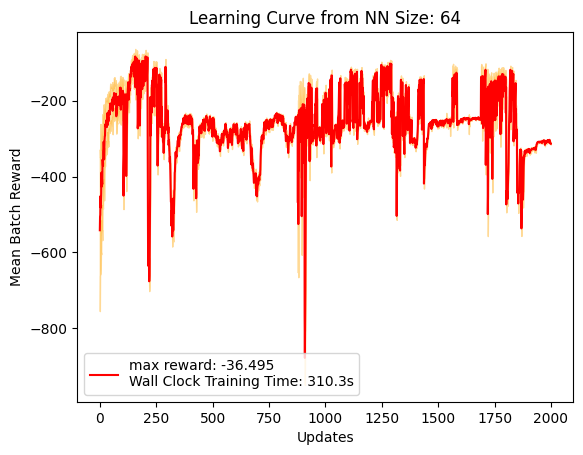

In [6]:
env_ind = 0
update_plot = 2000

x = np.arange(update_plot) # / update_plot * (end - start)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label=f'max reward: {int(1e3 * max_rewards[-1,0]) / 1e3}\nWall Clock Training Time: {int(1e1 *(end - start)) / 1e1}s', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Mean Batch Reward')
plt.title(f'Learning Curve from NN Size: {config["LAYER_SIZE"]}')
plt.show()

(2000, 8, 121)
0.1375
0.5389893875270408
0.8181626928548356


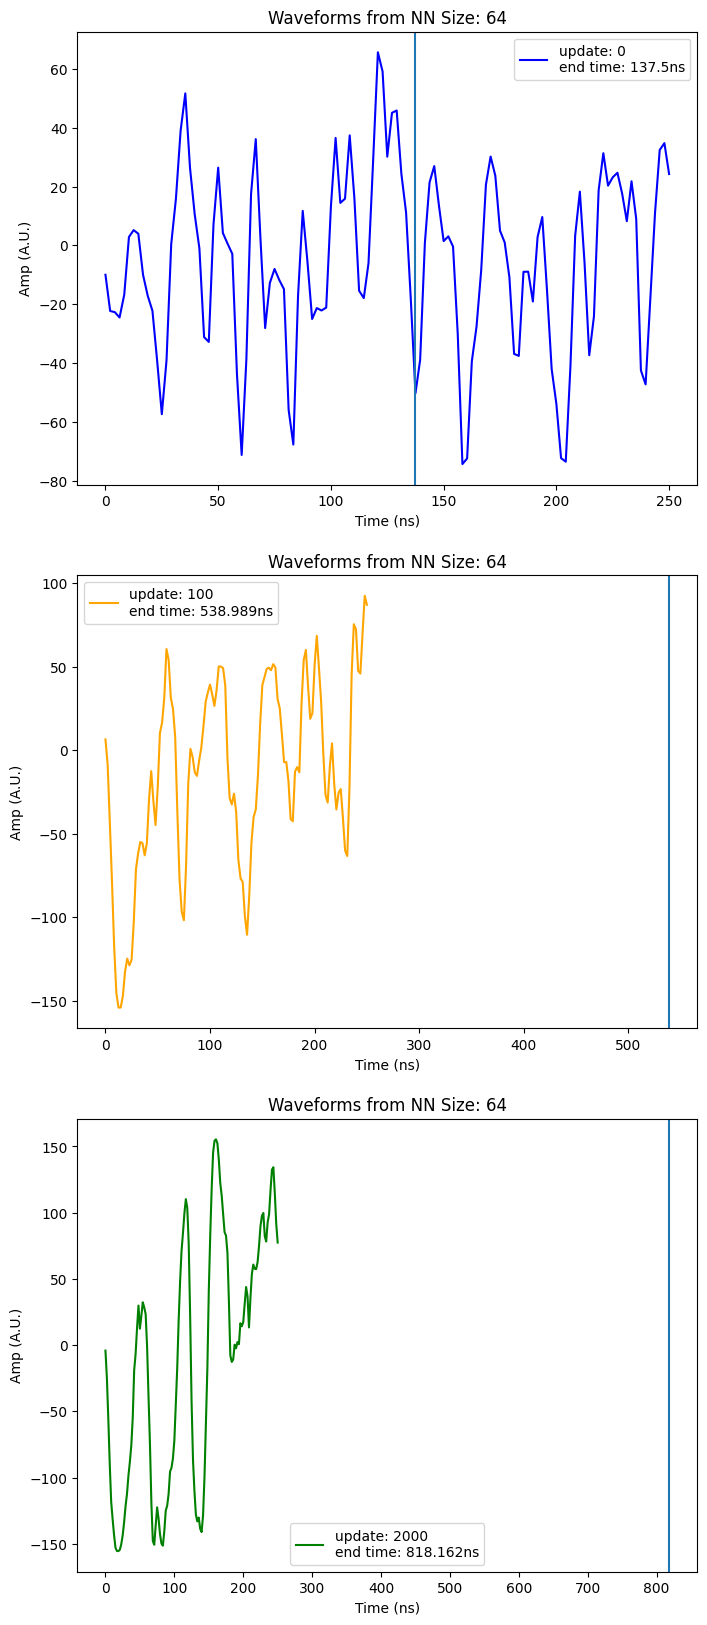

In [9]:
# Visualising Waveform Learning

plotting_updates = np.array([0, 100, 2000], dtype=np.int16)

print(max_actions.shape)

update_action = -max_actions[plotting_updates, 0]
action_linspace = np.linspace(0., num_t1 / kappa, update_action.shape[-1])

fig, ax = plt.subplots(len(plotting_updates), figsize=(8.0, 20.0))

color_list = ["blue", "orange", "green"]

for ind, action in enumerate(update_action):
    ax[ind].plot(action_linspace * 1e3, action, label=f'update: {plotting_updates[ind]}\nend time: {int(1e6 * max_times[plotting_updates[ind], 0]) / 1e3}ns', color=color_list[ind])
    ax[ind].axvline(x=1e6 * max_times[plotting_updates[ind], 0] / 1e3)
    print(max_times[plotting_updates[ind], 0])
    ax[ind].legend()
    ax[ind].set_xlabel('Time (ns)')
    ax[ind].set_ylabel('Amp (A.U.)')
    ax[ind].set_title(f'Waveforms from NN Size: {config["LAYER_SIZE"]}')
plt.show()